In [8]:
import covid_feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.var_model import VAR

In [56]:
def VAR_wrapper(input_X, input_y, save=False):
    
    train_frac = 0.85
    
    vector_data = pd.concat([input_y.reset_index(drop=True),input_X["total_cases"],input_X["deaths"],input_X["vaccine_allocations"]],axis=1)
    vector_data_train = vector_data.iloc[:int(train_frac*len(vector_data)),:]
    vector_data_test = vector_data.iloc[int(train_frac*len(vector_data)):,:]
    
    vector_data_diff = vector_data_train.diff().dropna()
    
    # check for stationarity after one differencing
    y_stationarity = adfuller(vector_data_diff[input_y.name])
    y_adf, y_pval = y_stationarity[0], y_stationarity[1]

    total_cases_stationarity = adfuller(vector_data_diff["total_cases"])
    total_cases_adf, total_cases_pval = total_cases_stationarity[0], total_cases_stationarity[1]

    death_stationarity = adfuller(vector_data_diff["deaths"])
    death_adf, death_pval = death_stationarity[0], death_stationarity[1]

    vax_stationarity = adfuller(vector_data_diff["vaccine_allocations"])
    vax_adf, vax_pval = vax_stationarity[0], vax_stationarity[1]

    print("Augmented Dickey–Fuller Test Results\n----------------------------------------")
    print("Y-Feature p-value: {}".format(y_pval))
    print("\nTotal Cases per 100k p-value: {}".format(total_cases_pval))
    print("\nDeaths per 100k p-value: {}".format(death_pval))
    print("\nVaccine Allocations p-value: {}".format(vax_pval))

    # plot MSE versus lag
    model = VAR(vector_data_diff)
    mse_vals = []
    aic_vals = []
    lag_range = np.arange(1,41,1)
    best_lag = 21

    for i in lag_range:
        result = model.fit(i)
        
        aic_vals.append(result.aic)
        
        lagged_data = vector_data_diff.values[-i:]

        forecast = result.forecast(y=lagged_data, steps=len(vector_data_test))
        forecast = pd.DataFrame(forecast, index=vector_data.index[-len(vector_data_test):], columns=vector_data.columns)
        forecast_copy = forecast.copy()

        cols = vector_data_train.columns
        for col in cols:        
            forecast_copy[str(col)+'_forecast'] = vector_data_train[col].iloc[-1] + forecast_copy[str(col)].cumsum()
        proper_forecast = forecast_copy.iloc[:,3:]

        mse = ((proper_forecast[input_y.name+"_forecast"] - vector_data_test[input_y.name])**2).mean()
        mse_vals.append(mse)
        
    print("Mean Squared-Error at Lag {}: {}".format(best_lag,mse_vals[list(lag_range).index(best_lag)]))
        
    fig = plt.figure(figsize=(12,4))

    plt.plot(lag_range, aic_vals, color='k')
    plt.axvline(best_lag,color='red',linestyle='--',label="Chosen Lag")
    plt.ylabel("Akaike Information Criterion")

    plt.legend()
    plt.show()
    
    # fit the chosen model and forecast
    fit_model = VAR(vector_data_diff,dates=dates[1:int(train_frac*len(vector_data))]).fit(best_lag)
    lag_num = fit_model.k_ar
    lagged_data = vector_data_diff.values[-lag_num:]
    
    forecast = fit_model.forecast(y=lagged_data, steps=len(vector_data_test))
    forecast = pd.DataFrame(forecast, index=vector_data.index[-len(vector_data_test):], columns=vector_data.columns)
    
    # undo the differencing
    forecast_copy = forecast.copy()
    cols = vector_data_train.columns
    for col in cols:        
        forecast_copy[str(col)+'_forecast'] = vector_data_train[col].iloc[-1] + forecast_copy[str(col)].cumsum()
    proper_forecast = forecast_copy.iloc[:,3:]
    
    fig, ax = plt.subplots(4,1,figsize=(18,15))

    ax[0].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["total_cases"],color='k',lw=1)
    ax[0].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["total_cases"],color='k',lw=1)
    ax[0].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["total_cases_forecast"],color='r',lw=1,linestyle='--')
    ax[0].tick_params(axis='x',bottom=False,labelbottom=False)
    ax[0].set_ylabel("Total Cases per 100k",fontsize=16)
    ax[0].tick_params(axis='both', which='major', labelsize=16)

    ax[1].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["deaths"],color='k',lw=1)
    ax[1].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["deaths"],color='k',lw=1)
    ax[1].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["deaths_forecast"],color='r',lw=1,linestyle='--')
    ax[1].tick_params(axis='x',bottom=False,labelbottom=False)
    ax[1].set_ylabel("Deaths per 100k",fontsize=16)
    ax[1].tick_params(axis='both', which='major', labelsize=16)

    ax[2].plot(dates[:int(train_frac*len(vector_data))],vector_data_train["vaccine_allocations"],color='k',lw=1)
    ax[2].plot(dates[int(train_frac*len(vector_data)):],vector_data_test["vaccine_allocations"],color='k',lw=1)
    ax[2].plot(dates[int(train_frac*len(vector_data)):],proper_forecast["vaccine_allocations_forecast"],color='r',lw=1,linestyle='--')
    ax[2].tick_params(axis='x',bottom=False,labelbottom=False)
    ax[2].set_ylabel("Vaccine Allocations",fontsize=16)
    ax[2].tick_params(axis='both', which='major', labelsize=16)

    ax[3].plot(dates[:int(train_frac*len(vector_data))],vector_data_train[input_y.name],color='k',lw=1)
    ax[3].plot(dates[int(train_frac*len(vector_data)):],vector_data_test[input_y.name],color='k',lw=1)
    ax[3].plot(dates[int(train_frac*len(vector_data)):],proper_forecast[input_y.name+"_forecast"],color='r',lw=1,linestyle='--')
    ax[3].set_ylabel(input_y.name,fontsize=16)
    ax[3].tick_params(axis='both', which='major', labelsize=16)

    if save:
        plt.savefig("georgia_VAR.png")
    plt.subplots_adjust(hspace = 0.1)
    plt.show()

# Population Not Staying Home

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 3.614480595724674e-05

Total Cases per 100k p-value: 0.021770471384510975

Deaths per 100k p-value: 1.8324720073792228e-09

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.0006720164059041749


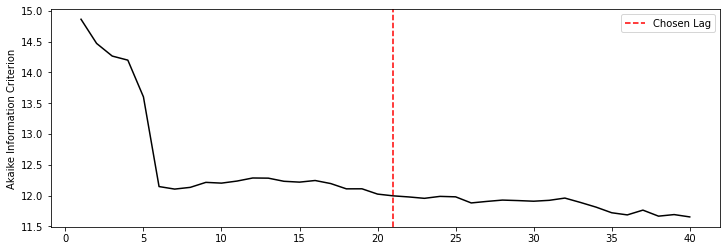

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


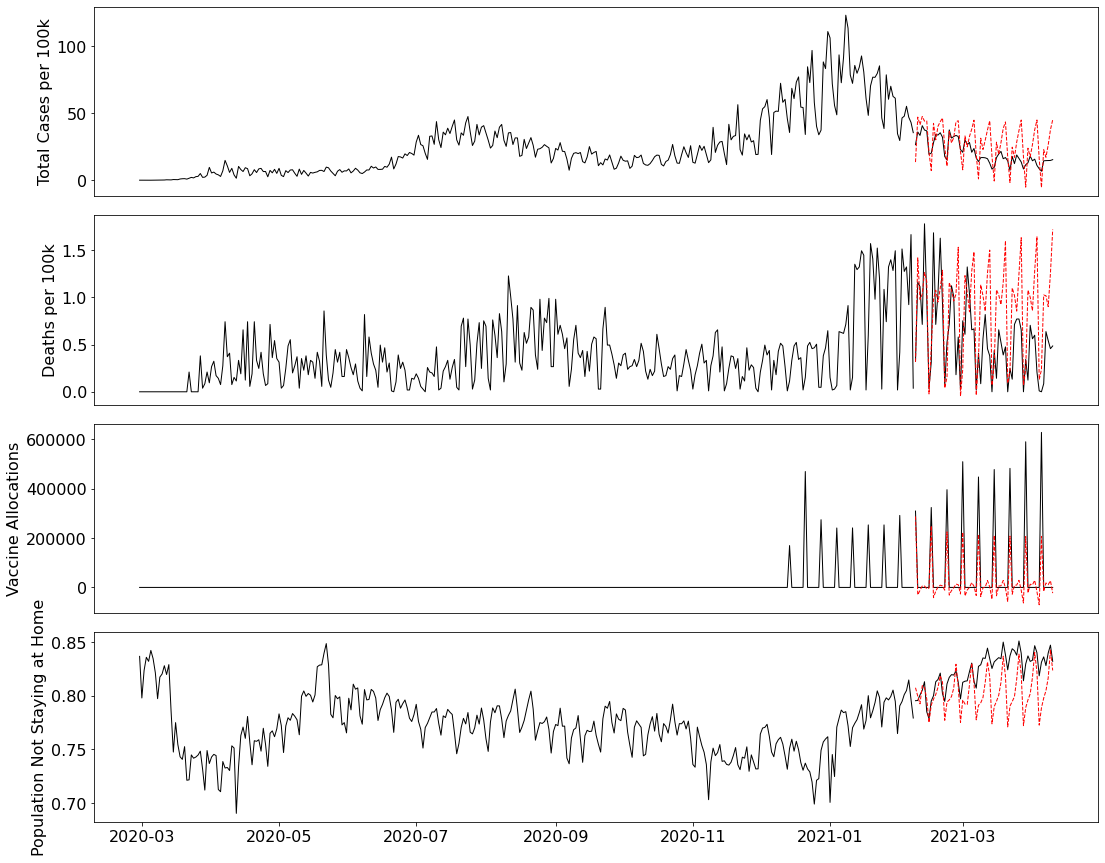

In [58]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Population")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Population")
dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Population")

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(state_X.shape[0]-len(dose_allocations),0))
state_X = pd.concat([state_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(state_X, state_y, save=True)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 8.130253465330708e-06

Total Cases per 100k p-value: 6.610864356542603e-05

Deaths per 100k p-value: 5.906561351476126e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.00039861625439748346


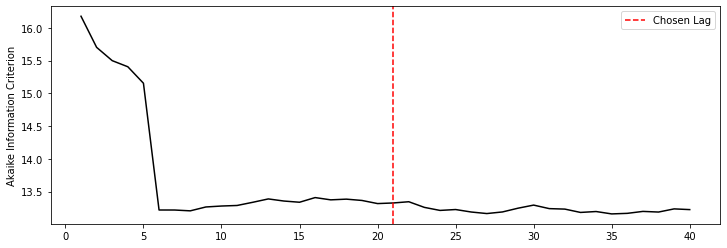

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


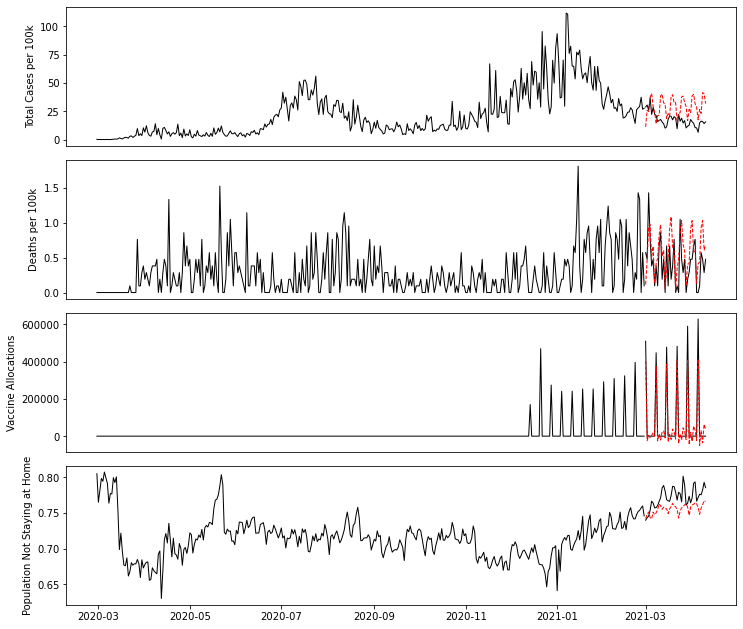

In [27]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Population")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Population")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Population")

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(fulton_X.shape[0]-len(dose_allocations),0))
fulton_X = pd.concat([fulton_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(fulton_X, fulton_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 7.455076044333392e-05

Total Cases per 100k p-value: 2.2118775350999836e-14

Deaths per 100k p-value: 2.908449522024725e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.0002857755128264586


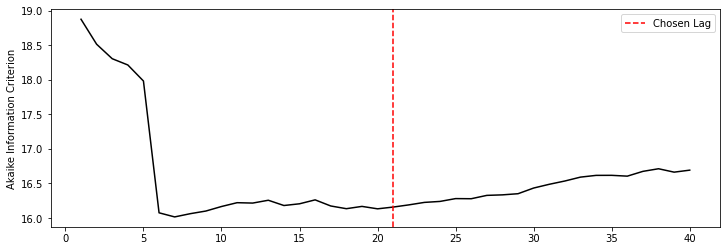

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


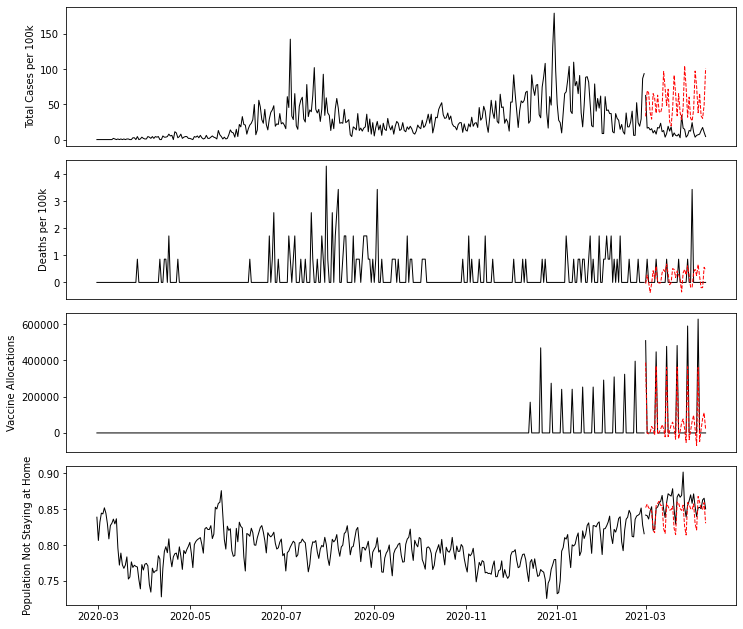

In [28]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Population")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Population")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Population")

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(lowndes_X.shape[0]-len(dose_allocations),0))
lowndes_X = pd.concat([lowndes_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(lowndes_X, lowndes_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 5.636567442427523e-05

Total Cases per 100k p-value: 0.0002020784832856038

Deaths per 100k p-value: 9.6263600118247e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.0001594744494716893


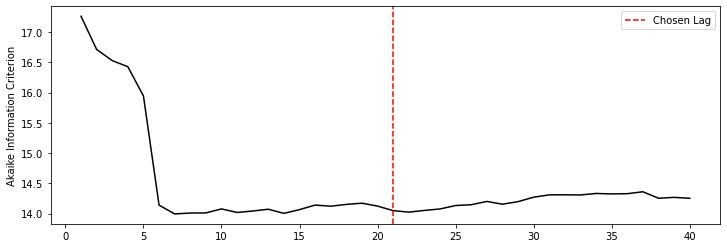

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


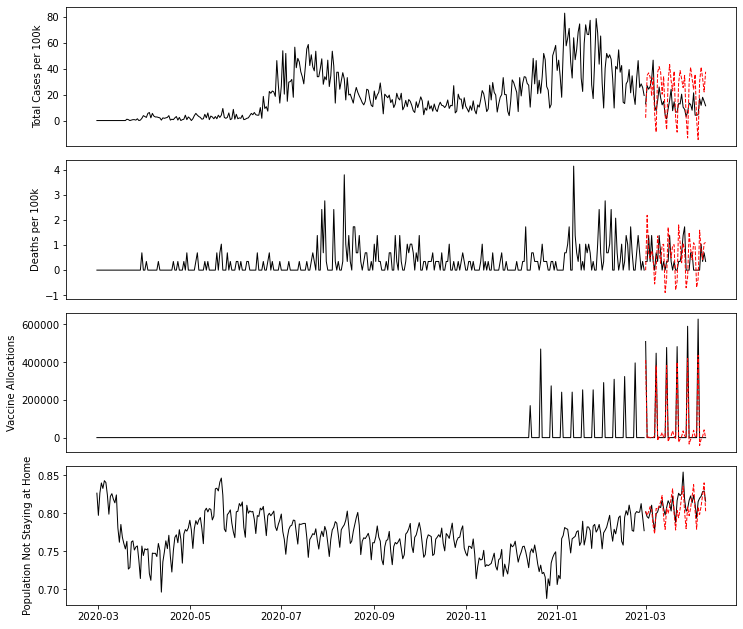

In [29]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Population")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Population")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Population")

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(chatham_X.shape[0]-len(dose_allocations),0))
chatham_X = pd.concat([chatham_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(chatham_X, chatham_y)

# Long Trips

Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 4.427649656956841e-10

Total Cases per 100k p-value: 0.007949965525030812

Deaths per 100k p-value: 0.0005904800175472461

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 1.276173454683168e-05


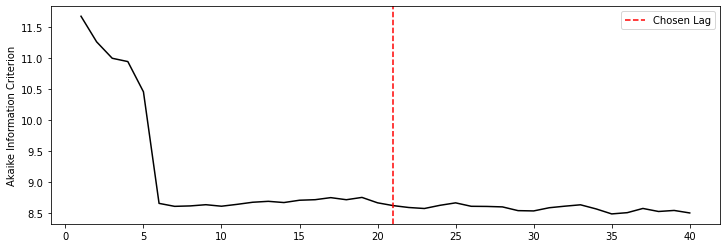

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


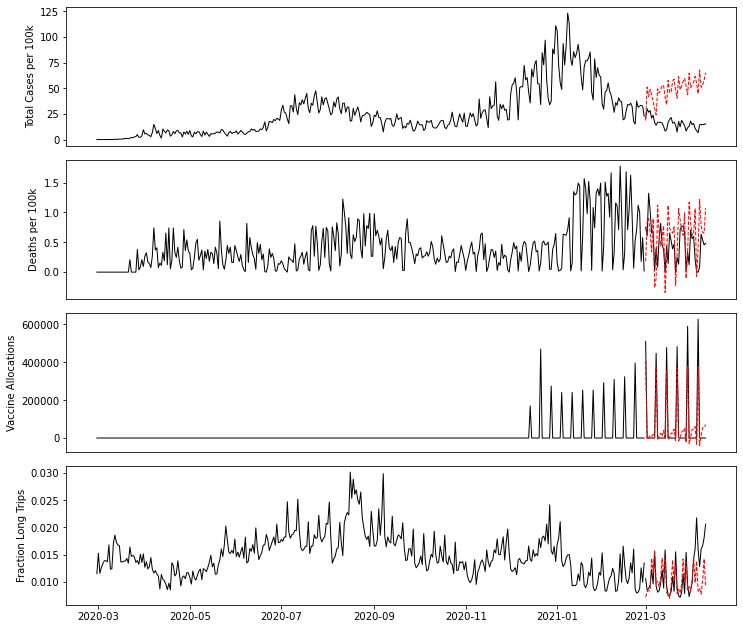

In [36]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Long")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Long")
dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Long")
state_y.name = "Fraction Long Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(state_X.shape[0]-len(dose_allocations),0))
state_X = pd.concat([state_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(state_X, state_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 3.800501691971338e-12

Total Cases per 100k p-value: 6.610864356542603e-05

Deaths per 100k p-value: 5.906561351476126e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 2.1719132425365754e-05


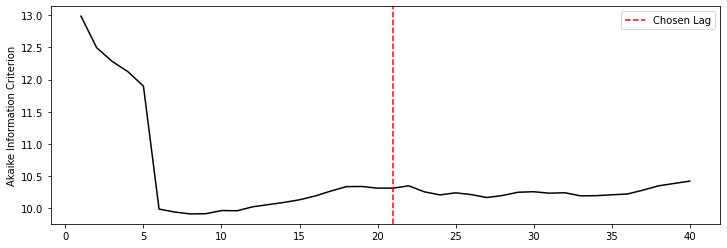

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


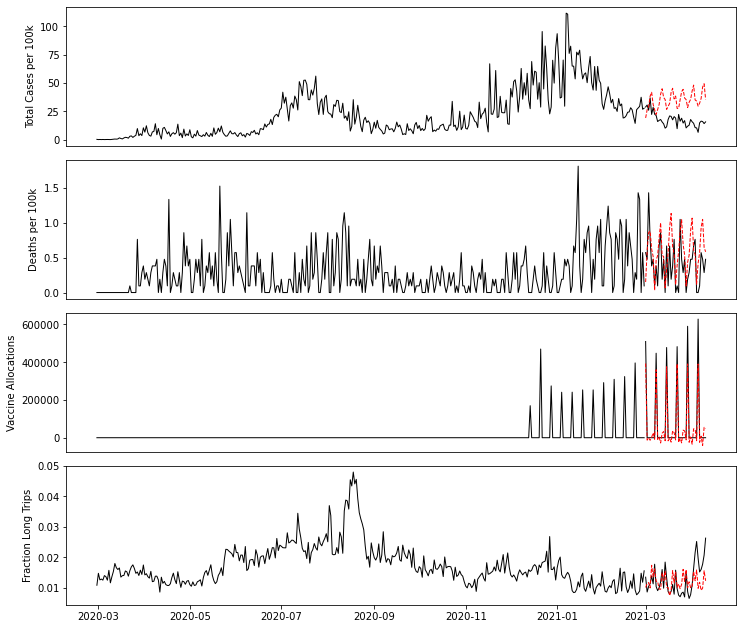

In [37]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Long")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Long")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Long")
fulton_y.name = "Fraction Long Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(fulton_X.shape[0]-len(dose_allocations),0))
fulton_X = pd.concat([fulton_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(fulton_X, fulton_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 2.8764355185731773e-05

Total Cases per 100k p-value: 2.2118775350999836e-14

Deaths per 100k p-value: 2.908449522024725e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 2.545471458728798e-05


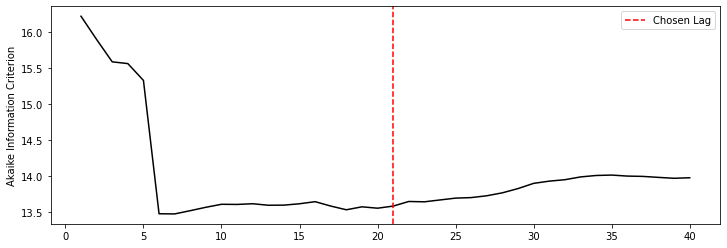

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


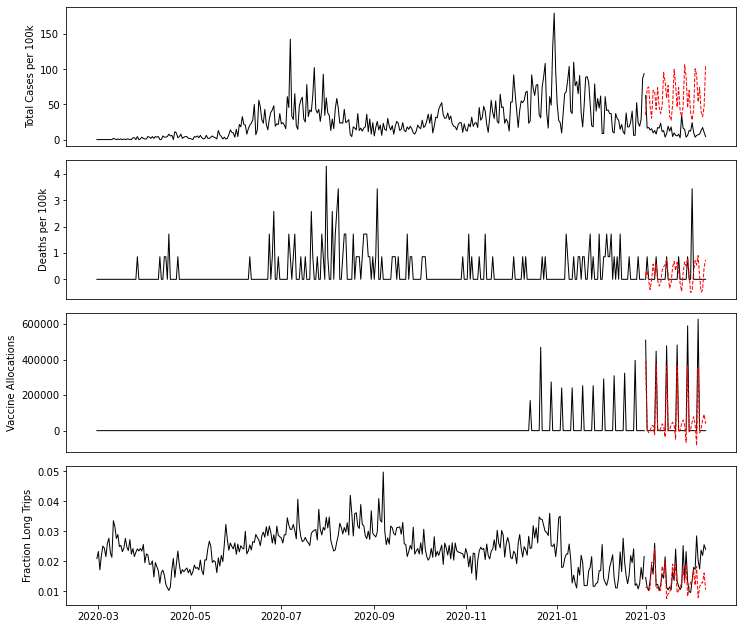

In [38]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Long")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Long")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Long")
lowndes_y.name = "Fraction Long Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(lowndes_X.shape[0]-len(dose_allocations),0))
lowndes_X = pd.concat([lowndes_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(lowndes_X, lowndes_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 8.642306936641682e-08

Total Cases per 100k p-value: 0.0002020784832856038

Deaths per 100k p-value: 9.6263600118247e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 7.0450046017296295e-06


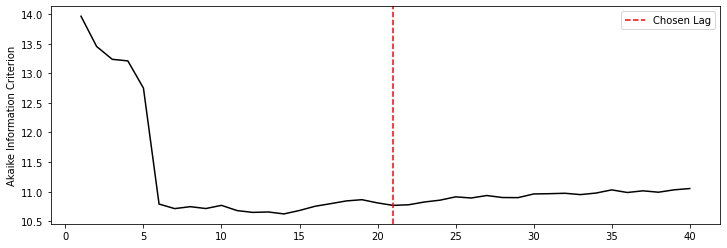

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


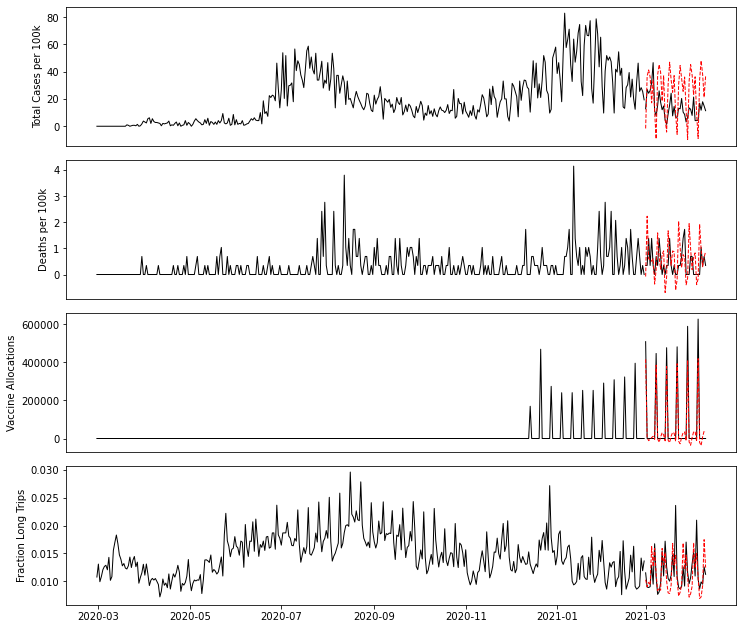

In [40]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Long")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Long")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Long")
chatham_y.name = "Fraction Long Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(chatham_X.shape[0]-len(dose_allocations),0))
chatham_X = pd.concat([chatham_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(chatham_X, chatham_y)

# Medium Trips

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 7.252721034335828e-06

Total Cases per 100k p-value: 0.007949965525030812

Deaths per 100k p-value: 0.0005904800175472461

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.00011065254664086931


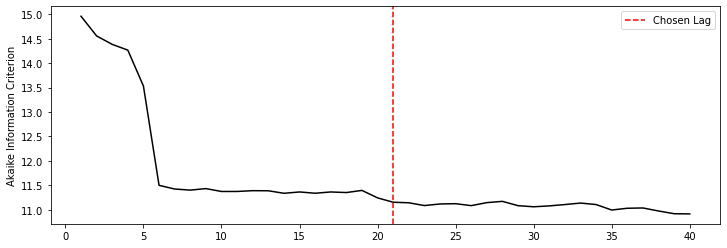

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


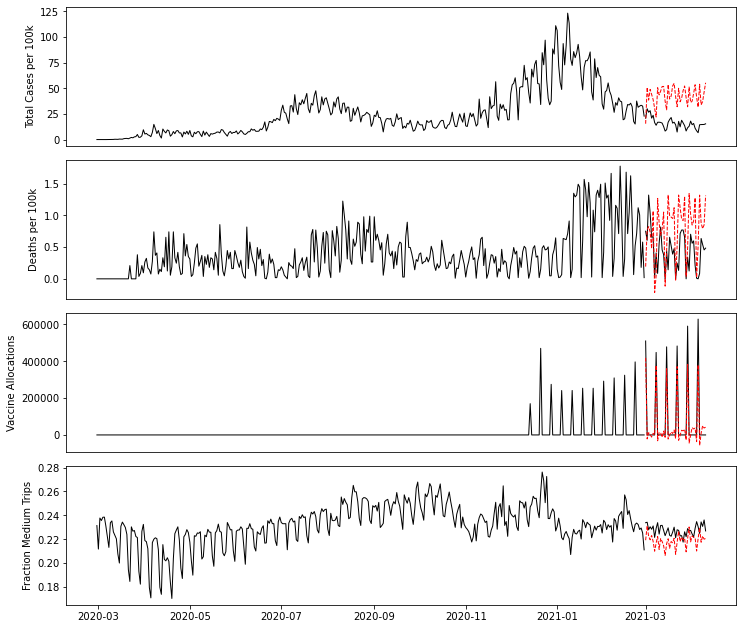

In [41]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Medium")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Medium")
dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Medium")
state_y.name = "Fraction Medium Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(state_X.shape[0]-len(dose_allocations),0))
state_X = pd.concat([state_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(state_X, state_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 3.23954939747879e-08

Total Cases per 100k p-value: 6.610864356542603e-05

Deaths per 100k p-value: 5.906561351476126e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.00014432103812683195


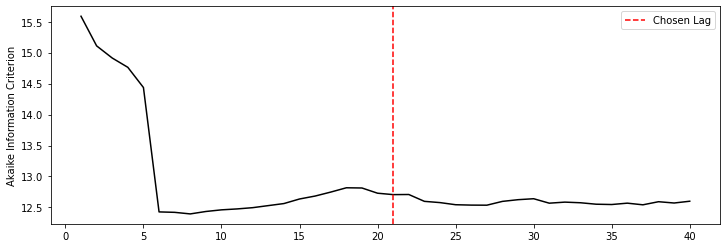

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


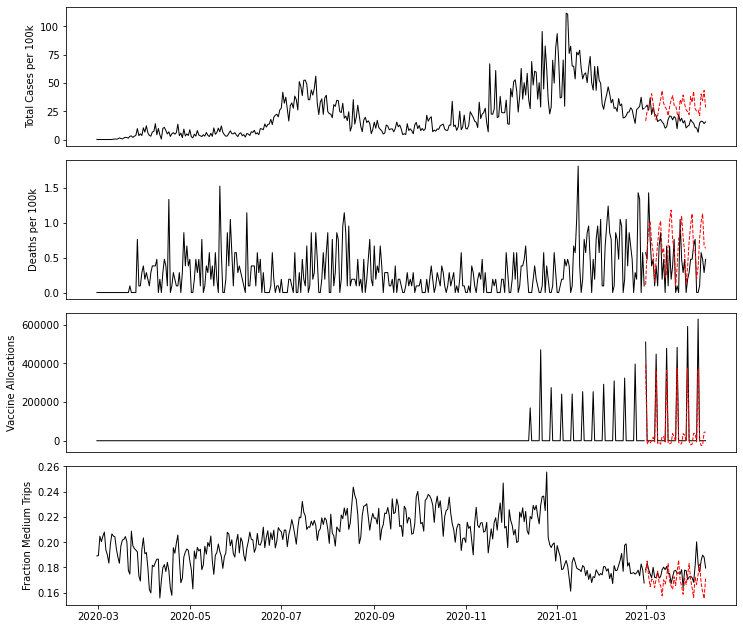

In [42]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Medium")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Medium")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Medium")
fulton_y.name = "Fraction Medium Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(fulton_X.shape[0]-len(dose_allocations),0))
fulton_X = pd.concat([fulton_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(fulton_X, fulton_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 1.001306978754104e-15

Total Cases per 100k p-value: 2.2118775350999836e-14

Deaths per 100k p-value: 2.908449522024725e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 9.407653656438504e-05


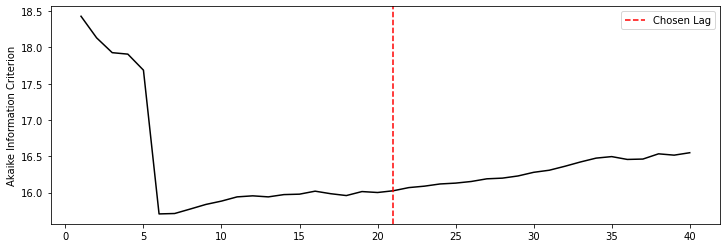

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


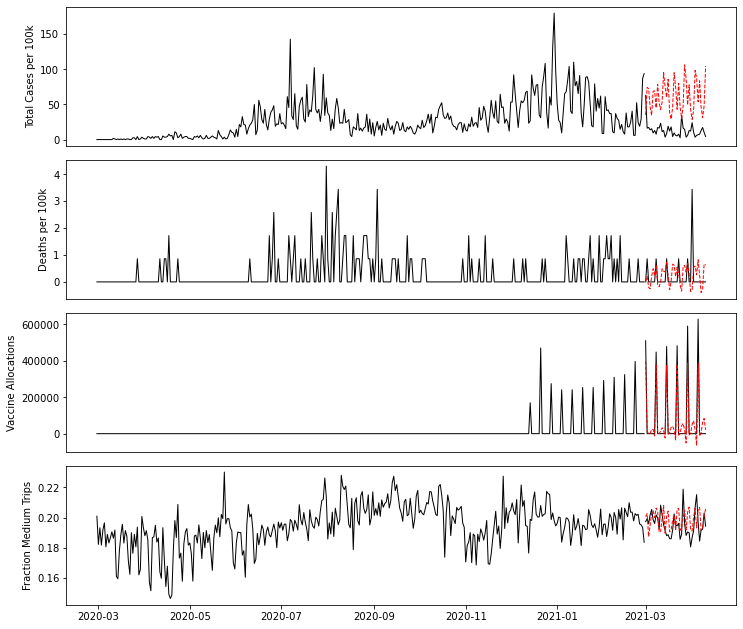

In [43]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Medium")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Medium")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Medium")
lowndes_y.name = "Fraction Medium Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(lowndes_X.shape[0]-len(dose_allocations),0))
lowndes_X = pd.concat([lowndes_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(lowndes_X, lowndes_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 3.2007399690804184e-11

Total Cases per 100k p-value: 0.0002020784832856038

Deaths per 100k p-value: 9.6263600118247e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 9.985979260570688e-05


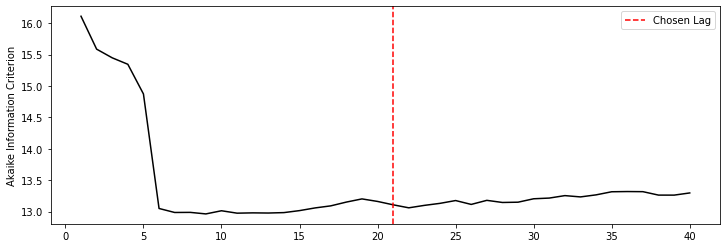

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


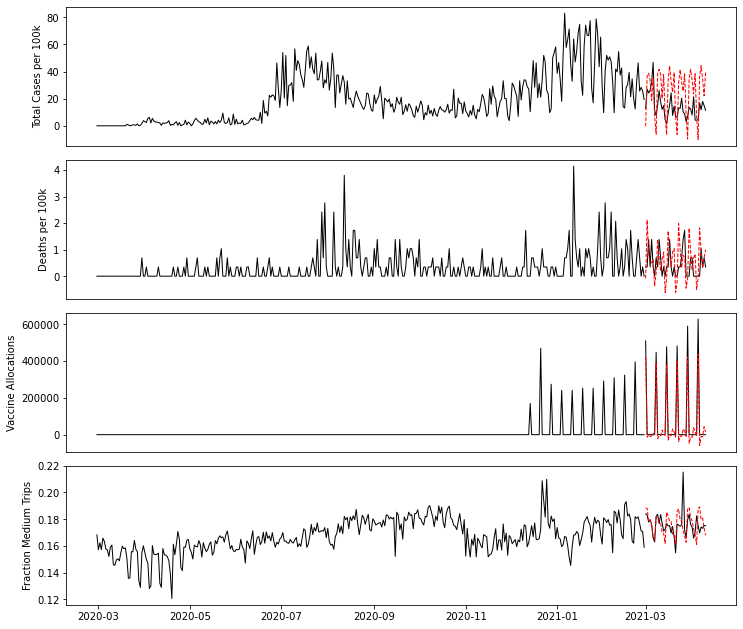

In [44]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Medium")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Medium")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Medium")
chatham_y.name = "Fraction Medium Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(chatham_X.shape[0]-len(dose_allocations),0))
chatham_X = pd.concat([chatham_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(chatham_X, chatham_y)

# Short Trips

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 7.663798243832278e-06

Total Cases per 100k p-value: 0.007949965525030812

Deaths per 100k p-value: 0.0005904800175472461

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.0001549886415215589


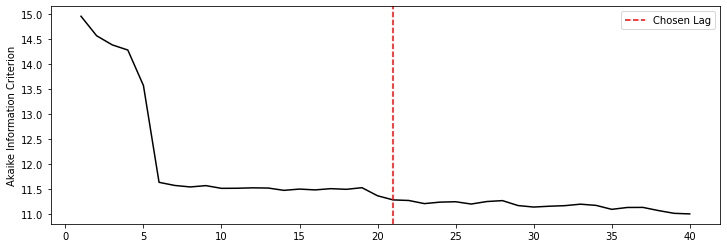

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


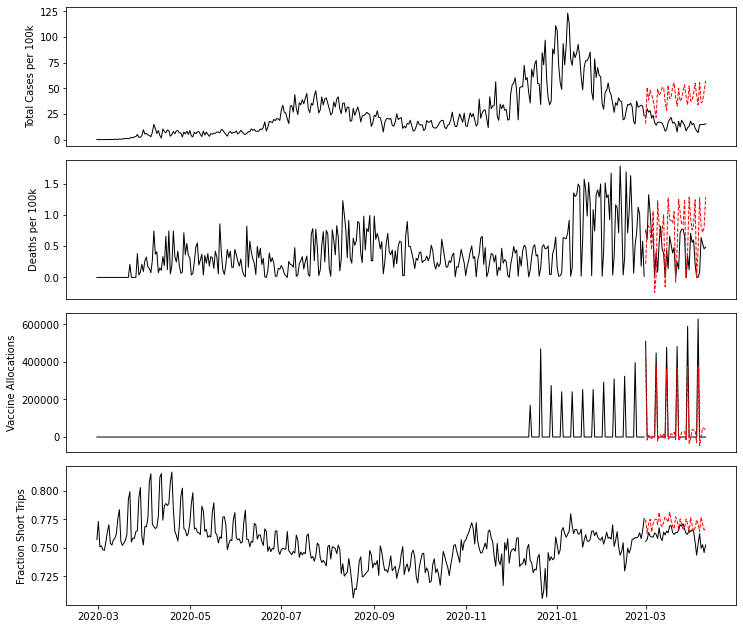

In [45]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Short")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Short")
dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Short")
state_y.name = "Fraction Short Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(state_X.shape[0]-len(dose_allocations),0))
state_X = pd.concat([state_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(state_X, state_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 8.045064334662186e-09

Total Cases per 100k p-value: 6.610864356542603e-05

Deaths per 100k p-value: 5.906561351476126e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.00020644777227598216


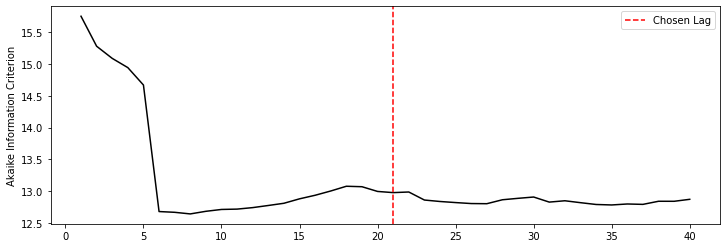

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


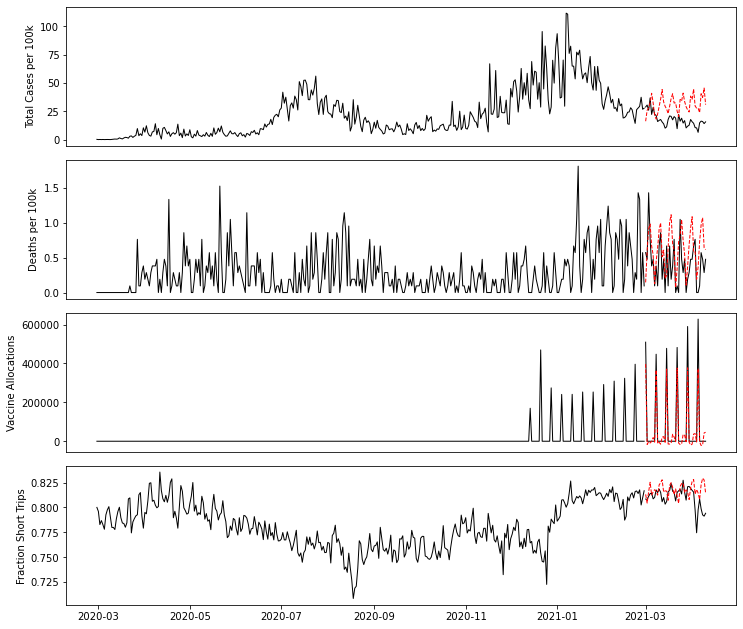

In [46]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Short")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Short")
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Short")
fulton_y.name = "Fraction Short Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(fulton_X.shape[0]-len(dose_allocations),0))
fulton_X = pd.concat([fulton_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(fulton_X, fulton_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 1.6700952288765995e-13

Total Cases per 100k p-value: 2.2118775350999836e-14

Deaths per 100k p-value: 2.908449522024725e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 0.00011666941501895477


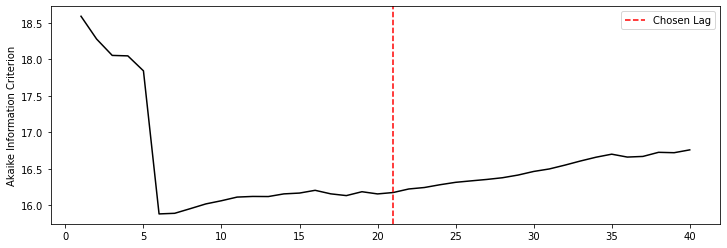

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


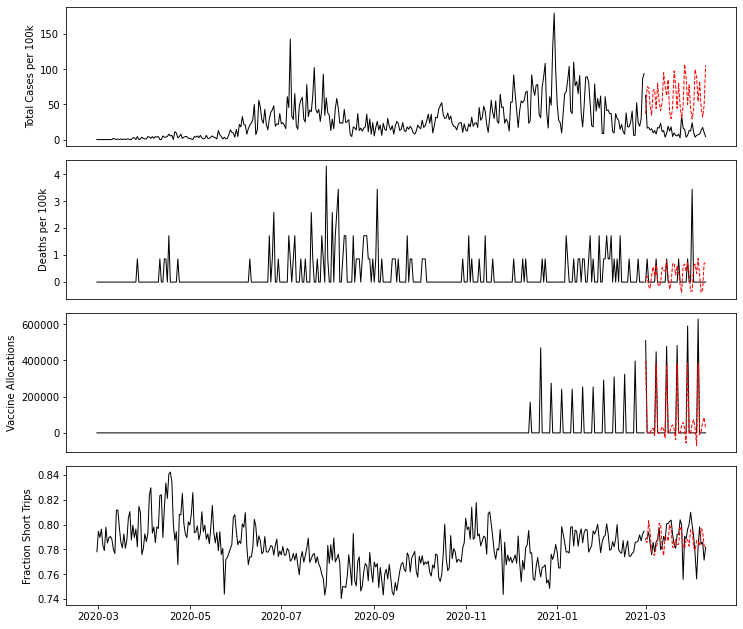

In [47]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Short")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Short")
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Short")
lowndes_y.name = "Fraction Short Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(lowndes_X.shape[0]-len(dose_allocations),0))
lowndes_X = pd.concat([lowndes_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(lowndes_X, lowndes_y)

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Augmented Dickey–Fuller Test Results
----------------------------------------
Y-Feature p-value: 2.1728874962814573e-11

Total Cases per 100k p-value: 0.0002020784832856038

Deaths per 100k p-value: 9.6263600118247e-14

Vaccine Allocations p-value: 0.0


C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Mean Squared-Error at Lag 21: 8.716519750468505e-05


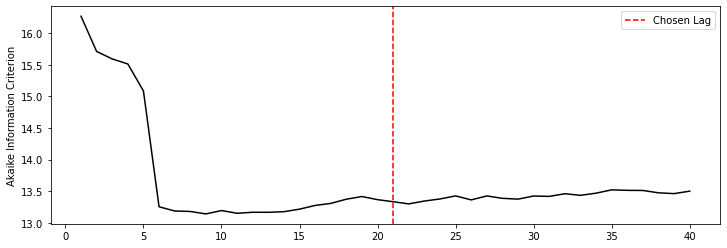

C:\Users\Matt\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


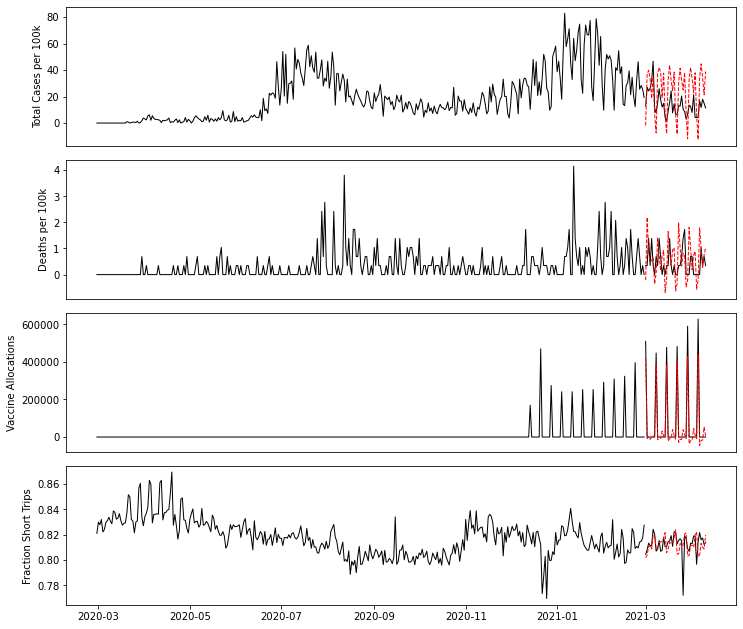

In [48]:
alloc_dates, state_y, first_dose = covid_feature_extraction.first_dose("Georgia","GA","Short")
alloc_dates, state_y, second_dose = covid_feature_extraction.second_dose("Georgia","GA","Short")
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Short")
chatham_y.name = "Fraction Short Trips"

dose_allocations = first_dose+second_dose

padded_doses = np.pad(dose_allocations,pad_width=(chatham_X.shape[0]-len(dose_allocations),0))
chatham_X = pd.concat([chatham_X,pd.Series(padded_doses,name="vaccine_allocations")],axis=1)

VAR_wrapper(chatham_X, chatham_y)